# 0. 初始化

In [1]:
import os
import json
from tqdm import tqdm
from utils.call_gpt import call_gpt, call_gpt_async

## 0.1 Human Env

In [2]:
import pandas as pd
import re
import os
from collections import defaultdict

def process_source(df, prefix):
    """处理单个数据源（Gen或GT）"""
    # 添加前缀
    df[f"{prefix}_MEU_id"] = prefix + "_" + df["MEU_id"]
    
    # 去重处理（保留第一个出现的）
    df = df.drop_duplicates(subset=[f"{prefix}_MEU_id"], keep='first')
    
    # 解析编号
    def parse_numbers(meu_id):
        match = re.match(rf"^{prefix}_MEU_(\d+)_(\d+)$", meu_id)
        if match:
            return int(match.group(1)), int(match.group(2))
        return (None, None)
    
    df[["Law", "i"]] = df[f"{prefix}_MEU_id"].apply(
        lambda x: pd.Series(parse_numbers(x))
    )
    
    # 过滤无效数据
    df = df[df["Law"].notna()].copy()
    
    # 按Law分组并按i排序
    grouped = defaultdict(list)
    for _, row in df.iterrows():
        law = row["Law"]
        grouped[law].append(row)
    
    # 对每个Law内的数据按i排序
    sorted_data = []
    for law in sorted(grouped.keys()):
        law_data = sorted(grouped[law], key=lambda x: x["i"])
        sorted_data.extend(law_data)
    
    return pd.DataFrame(sorted_data)

# 读取并处理Gen数据
gen_raw = pd.read_excel(
    "law_to_MEU/st_3_0_MEU/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.xlsx",
    usecols=["MEU_id", "subject", "condition", "constraint", "contextual_info"]
)
gen_processed = process_source(gen_raw, "Gen")

# 读取并处理GT数据
gt_raw = pd.read_excel(
    "law_to_MEU/st_3_0_MEU/GT/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.xlsx",
    usecols=["MEU_id", "subject", "condition", "constraint", "contextual_info", "comment"]
)
gt_processed = process_source(gt_raw, "GT")

# 构建合并数据结构
final_rows = []
law_set = sorted(set(gen_processed["Law"].unique()).union(gt_processed["Law"].unique()))

for law in law_set:
    # 获取当前Law的数据
    gen_law = gen_processed[gen_processed["Law"] == law]
    gt_law = gt_processed[gt_processed["Law"] == law]
    
    # 确定最大长度
    max_length = max(len(gen_law), len(gt_law))
    
    # 对齐数据
    for idx in range(max_length):
        row = {"Law": law}
        
        # 处理Gen数据
        if idx < len(gen_law):
            gen_row = gen_law.iloc[idx]
            row.update({
                "Gen_MEU_id": gen_row["Gen_MEU_id"],
                "Gen_subject": gen_row["subject"],
                "Gen_condition": gen_row["condition"],
                "Gen_constrain": gen_row["constraint"],
                "Gen_contextual_info": gen_row["contextual_info"]
            })
        else:
            row.update({k: "" for k in ["Gen_MEU_id", "Gen_subject", "Gen_condition", "Gen_constrain", "Gen_contextual_info"]})
        
        # 处理GT数据
        if idx < len(gt_law):
            gt_row = gt_law.iloc[idx]
            row.update({
                "GT_MEU_id": gt_row["GT_MEU_id"],
                "GT_subject": gt_row["subject"],
                "GT_condition": gt_row["condition"],
                "GT_constrain": gt_row["constraint"],
                "GT_contextual_info": gt_row["contextual_info"]
            })
        else:
            row.update({k: "" for k in ["GT_MEU_id", "GT_subject", "GT_condition", "GT_constrain", "GT_contextual_info"]})
        
        # 添加空白列
        row["blank"] = ""
        row["been_responsed_by"] = ""
        row["state"] = ""
        
        final_rows.append(row)
    
    # 添加法条分隔行
    final_rows.append({
        "Law": "blank",
        **{col: "" for col in ["Gen_MEU_id", "Gen_subject", "Gen_condition", "Gen_constrain", "Gen_contextual_info",
                              "GT_MEU_id", "GT_subject", "GT_condition", "GT_constrain", "GT_contextual_info",
                              "blank", "been_responsed_by", "state"]}
    })

# 创建最终DataFrame
final_df = pd.DataFrame(final_rows)

# 调整列顺序
column_order = [
    'Law', 'Gen_MEU_id', 'Gen_subject', 'Gen_condition', 'Gen_constrain', 'Gen_contextual_info',
    'blank',
    'GT_MEU_id', 'GT_subject', 'GT_condition', 'GT_constrain', 'GT_contextual_info',
    'been_responsed_by', 'state'
]
final_df = final_df[column_order]
final_df['comments'] = ''

# 保存结果
output_path = "evaluate_MEU/experiment_1/human_env/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.xlsx"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

final_df.to_excel(output_path, index=False, sheet_name="All_Laws")

print(f"处理完成！共处理法条数量：{len(law_set)}")
print(f"生成数据示例：")
print(final_df.head(10).to_markdown(index=False))

处理完成！共处理法条数量：29
生成数据示例：
| Law   | Gen_MEU_id   | Gen_subject                                                   | Gen_condition                                                              | Gen_constrain                                              | Gen_contextual_info                                                                                                                                                                                                                                                                                              | blank   | GT_MEU_id   | GT_subject                         | GT_condition                                                               | GT_constrain                                               | GT_contextual_info                                                                                                                                                                                                                                 

# 1. Prompt模板与测试

## 1.1 Prompt模板: 实验1: 每个GT_MEU是否被Gen_MEU完整回应

In [3]:
prompt_MEU_eval_exp_1 = """
# 法律最小可执行单元评估任务

## 身份
你是一名专业的律师和语言学家, 专注于评估由LLM生成的最小可执行单元(Minum Executable Unit, MEU)和人类标注的ground truth之间的一致性. 

## MEU概念简述
MEU (Minimum Executable Unit) 是法律条文拆解出的最小合规单元，包含：
- MEU_id: MEU的编号, 通常为"MEU_n_k", 其中n是其所属的法条的编号, k是其在法条内部的编号
- subject: 责任主体 (如"控股股东") 
- condition: 触发条件 (如"减持股份")  
- constraint: 约束内容 (如"提前15日公告") 
- contextual_info: 补充说明 (如价格计算方式) 
我们采用MEU判断案例的合规性时, 会先检查案例主体是否符合MEU主体, 再检查案例中的条件是否符合MEU中的条件, 当前两者都满足, 再检查案例中的主体的行为是否违反了MEU中的约束. 只有主体, 条件和约束全部满足, 才会认为该案例在该MEU上违规, 否则会判定该案例在该MEU上不违规. 

GT_MEU: 人类专家标注的Ground Truth的MEU, 必定准确, 是我们评估的基础
Gen_MEU: 由语言模型生成的MEU, 不一定能够准确反映GT_MEU, 是我们评估的对象
MEU的编码: MEU_n_k表示某法律法规文件下第n个法条的第k个MEU. 例如, 某法律法规文件的第5个法条的第3个MEU的ground truth是GT_MEU_5_7

## 核心任务
读取GT_MEU的列表, 对于每一个GT_MEU, 首先判断其被哪些Gen_MEU回应, 记录下这些Gen_MEU的编号; 其次, 判断其是否整体上被正确回应(两个state: correct, wrong), 也即回应它的所有的Gen_MEU是否正确地表示了它所有的语义. 

- 回复的答案应当是一个字典, 用<EVALUATE><EVALUATE>标签包裹. 

  <EVALUATE>
  {{
    "GT_MEU_9_1": {{
      "been_responsed_by": ["Gen_MEU_9_1", "Gen_MEU_9_2"],
      "state": "correct",
      "comment": "两个Gen_MEU共同完整表达了GT_MEU的语义"
    }},
    "GT_MEU_9_2": {{
      "been_responsed_by": ["Gen_MEU_9_3"],
      "state": "correct",
      "comment": "语义和逻辑约束完全匹配"
    }},
    "GT_MEU_9_3": {{
      "been_responsed_by": [],
      "state": "wrong",
      "comment": "未被任何Gen_MEU回应"
    }},
    "GT_MEU_9_4": {{
      "been_responsed_by": ["Gen_MEU_9_4", "Gen_MEU_9_5"],
      "state": "wrong",
      "comment": "Gen_MEU的约束条件比GT_MEU的更为严格, 在逻辑上不等价, 属于错误回应"
    }},
  }}
  </EVALUATE>

- 评估的宗旨: 从语义和逻辑的角度进行评估. 
- GT_MEU之间也并不是孤立的, 可能存在逻辑关系. 如果GT_MEU_n_j否定了GT_MEU_n_i, 而Gen_MEU_n_i包含了整个的"GT_MEU_n_j否定了GT_MEU_n_i"的关系, 那么视为这两个GT_MEU都被正确回应了. 
- 有时候待评估MEU的拆分方式和GT_MEU的拆分方式不一样, 可能存在多个待评估MEU回应同一个GT_MEU的情况. 这时应当从法律的语义和逻辑上理解: 这些待评估MEU的并集是否和对应的GT_MEU等价? MEU可以产生"违规"或者"不违规"的两种运算结果, 同个法条产生的一簇MEU之间用并集运算, 当一个MEU违约时标记为整个法条违约. 如果在考虑逻辑运算后这些待评估MEU仍然与GT_MEU等价, 那么可以标记该GT_MEU被正确回应. 
- 你获取的GT_MEU除了主体, 条件, 约束内容之外, 还有comment这个属性, 这是标注人员在标注过程中对评分留下的批注, 如果其中有一些要求, 你需要在评分中遵守. 例如, 有的comment会提到"如果没有主体, 直接把主体放在contextual_info也算对", 那么对于该GT中的MEU, 如果待评估的MEU没有subject而是直接把subject写在contextual_info中, 也算作被正确回应. 
- MEU_id 只是编码, 没有实际意义也不参与评估, 可能Gen_MEU_n_i和Gen_MEU_n_k一起回应了GT_MEU_n_i, 那么仍然正确. 

## MEU中并列关系的处理
- condition中的"或"可以拆分成不同MEU. 例如: GT_condition"股份减持计划实施完毕或者披露的减持时间区间届满"可以被拆分为"股份减持计划实施完毕"和"披露的减持时间区间届满", 这样在分别执行时与原先的condition覆盖的范围是等价的. 
- condition中的"且"不可拆分为多个MEU. 例如, GT_condition"拟在3个月内通过集中竞价交易减持股份, 且拟减持股份总数超过公司股份总数1%"如果拆分为"拟在3个月内通过集中竞价交易减持股份"和"拟减持股份总数超过公司股份总数1%", 则第一条是显著放宽了要求, 覆盖了更多的情况; 而第二条损失了"3个月内", "集中竞价交易"等信息, 完全是对原先GT_MEU的错误回应. 
- constrain中的"或"不可拆分为多个MEU. 例如, GT_constrain中称"应当及时向中国证监会或本所报告", 那么该主体只需向其中一个机构报告即可, 如果强行拆分则需要向两个机构都报告, 是对原先GT_MEU的错误回应. 
- constrain中的"且"可以拆分为多个MEU. 由于MEU的独立执行的特性, GT_constrain中的并列的要求可以被拆分到不同的MEU中分别检验, 最后覆盖范围与原MEU一致. 

## 更多评估规则
- 检查condition的时候需要注意Gen_MEU是否省略了一些必要的前提. 例如, Law_9讨论公司上市时未盈利且现在仍未盈利的情况, 某个Gen_MEU_9_j记录了"董监高 公司实现盈利后 可以减持公司的股份", 就遗漏了condition, 完整的应该为"公司上市时未盈利的，在公司实现盈利后". 
- 检查constrain时可以和相应的condition一起看, 如果Gen_MEU的condition和constrain只是部分内容顺序不一样, 但仍然和GT_MEU的法律实质相同, 也算正确. 例如, "通过协议转让方式减持股份导致其不再具有控股股东、实际控制人身份的, 应当在减持后6个月内继续遵守本指引第十二条第一款第二、三项规定", 这里的"...应当在减持后6个月内..."可以放在condition或者constrain, 只要连起来语义没有损失. 
- 放在constrain这一栏的数据本身就蕴含"应当这么做"的语义, 如果没有显式写出"应当", 此外没有其他情况导致语义不一致的, 也不算错误. 
- 检查contextual_info的时候, 需要确认该部分内容是否本应属于condition或constrain. 对于"某主体可以做某事"的表述, 如果蕴含"该主体不这么做就会受到惩罚"的语义, 那么气本质上还是属于constrain; 如果是单纯的表示该主体可以进行某个操作, 那么属于contextual_info. 
- 检查contextual_info的时候, 需要确认该部分是否蕴含"应当遵循某个条款", "应当受到某种限制"的情况. 如是则判错, 因为这两种情况应当放入condition和constrain. contextual_info可以存放某些主体的认定方式, 某些指标的计算方式, 非约束性质的权利赋予等内容, 不能存放有实际约束意义的文本. 
- 当某个MEU是表示一些定义, 一些实体的认定方式, 一些指标的计算方式时, 我们鼓励将这些信息全部放在contextual_info, 但从实用角度出发, 我们对subject, condition, constrain和contextual_info之间的划分会较为宽松. 只要这三个属性连起来完整地包含了该认定方式/计算规则的语义, 就可判为正确. 


## 更多案例

### 案例1

▶ GT_MEU:
[{{'MEU_id': 'GT_MEU_9_1',
  'subject': '控股股东 | 实际控制人 | 董监高',
  'condition': '公司上市时未盈利且处于实现盈利前阶段',
  'constraint': '自公司股票上市之日起2个完整会计年度内不得减持公开发行并上市前股份',
  'contextual_info': nan,
  'comment': nan}},
 {{'MEU_id': 'GT_MEU_9_2',
  'subject': '控股股东 | 实际控制人 | 董监高',
  'condition': '公司上市时未盈利的，在公司实现盈利后',
  'constraint': '可以自当年年度报告披露后次日起减持公开发行并上市前股份，但应遵守《上市规则》及本指引相关规定',
  'contextual_info': nan,
  'comment': ''}},
 {{'EU_id': 'GT_MEU_9_3',
  'subject': '董监高',
  'condition': '在前款规定的2个完整会计年度期间内离职',
  'constraint': '应当继续遵守前款规定的减持限制',
  'contextual_info': nan,
  'comment': nan}}]

▶ Gen_MEU:
[{{'MEU_id': 'MEU_9_1',
  'subject': '控股股东 | 实际控制人 | 董监高',
  'condition': '公司上市时未盈利且处于实现盈利前阶段',
  'constraint': '自公司股票上市之日起2个完整会计年度内不得减持公开发行并上市前股份',
  'contextual_info': nan}},
 {{'MEU_id': 'MEU_9_2',
  'subject': '控股股东 | 实际控制人 | 董监高',
  'condition': '公司实现盈利后',
  'constraint': '可以自当年年度报告披露后次日起减持公开发行并上市前股份',
  'contextual_info': '减持应遵守《上市规则》及本指引相关规定'}},
]

▶ Answer:
<EVALUATE>
{{
  "GT_MEU_9_1": {{
    "been_responsed_by": ["Gen_MEU_9_1"],
    "state": "correct",
    "comment": "主体, 条件和约束均一致, 是正确的拆分"
  }},
  "GT_MEU_9_2": {{
    "been_responsed_by": ["Gen_MEU_9_2"],
    "state": "wrong",
    "comment": "condition部分遗漏了'公司上市时未盈利的，', constrain部分的'减持应遵守《上市规则》及本指引相关规定'是约束, 被错误地放在了contextual_info"
  }},
  "GT_MEU_9_3": {{
    "been_responsed_by": [],
    "state": "wrong",
    "comment": "未被任何Gen_MEU回应"
  }},
}}
</EVALUATE>


## 下面轮到你来处理

▶ GT_MEU:
{Law_n_ground_truth}

▶ Gen_MEU:
{Law_n_generated_result}

▶ 输出格式
在生成正式答案前, 你可以进行任意长度的思考;
在生成正式答案时, 请用<EVALUATE></EVALUATE>包裹你的正式答案, 答案内不要有注释等多余内容
"""

In [ ]:
""" 
上市公司	因维护公司价值及股东权益所必需而回购且发生本指引第四条规定的相关事实	应当自相关事实发生之日起10个交易日内召开董事会审议回购股份方案
上市公司	因维护公司价值及股东权益所必需而回购且发生本指引第四条规定的相关事实, 自相关事实发生之日起10个交易日内	 应当召开董事会审议回购股份方案
"""

## 1.2 读取 GT_MEU

In [4]:
import pandas as pd
import re

# 定义文件路径和要提取的列
file_path = "law_to_MEU/st_3_0_MEU/GT/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.xlsx"
columns_to_extract = ["MEU_id", "subject", "condition", "constraint", "contextual_info", "comment"]

# 读取CSV文件
df = pd.read_excel(file_path)

# 提取所需的列
extracted_df = df[columns_to_extract]

# 提取MEU_id中的n
def extract_n(meu_id):
    match = re.match(r'MEU_(\d+)_\d+', meu_id)
    if match:
        return int(match.group(1))
    return None


extracted_df['n'] = extracted_df['MEU_id'].apply(extract_n)
extracted_df['MEU_id'] = "GT_" + extracted_df['MEU_id']
grouped = extracted_df.groupby('n')
Law_n_ground_truth_list = [group.drop(columns=['n']).to_dict(orient="records") for _, group in grouped]

# 打印部分结果示例
Law_n_ground_truth_list[11]

[{'MEU_id': 'GT_MEU_12_1',
  'subject': '公开发行股票并上市时的控股股东 | 公开发行股票并上市时的实际控制人',
  'condition': '计划通过集中竞价交易或大宗交易减持股份且首次披露减持计划, 且不存在已经按照本指引第四条披露减持计划，或者中国证监会另有规定的情况的',
  'constraint': '不得存在下列情形：最近20个交易日内任一交易日股票收盘价低于公开发行股票并上市的发行价格',
  'contextual_info': '股票收盘价以公开发行股票并上市之日为基准向后复权计算',
  'comment': '需要考虑怎么体现: 上市后不再具备相关主体身份的，也应遵守该项规定。'},
 {'MEU_id': 'GT_MEU_12_2',
  'subject': '上市公司控股股东 | 实际控制人 | 一致行动人',
  'condition': '计划通过集中竞价交易或大宗交易减持股份且首次披露减持计划, 且不存在已经按照本指引第四条披露减持计划，或者中国证监会另有规定的情况的',
  'constraint': '不得存在下列情形：最近20个交易日内，上市公司任一交易日股票收盘价低于最近一个会计年度或者最近一期财务会计报告期末每股归属于上市公司股东的净资产',
  'contextual_info': '股票收盘价以最近一个会计年度或者最近一期财务会计报告资产负债表日为基准分别向后复权计算',
  'comment': nan},
 {'MEU_id': 'GT_MEU_12_3',
  'subject': '上市公司控股股东 | 实际控制人 | 一致行动人',
  'condition': '计划通过集中竞价交易或大宗交易减持股份且首次披露减持计划, 且不存在已经按照本指引第四条披露减持计划，或者中国证监会另有规定的情况的',
  'constraint': '不得存在下列情形：上市公司最近一期经审计的财务报告的归属于上市公司股东的净利润为负',
  'contextual_info': nan,
  'comment': nan},
 {'MEU_id': 'GT_MEU_12_4',
  'subject': '控股股东 | 实际控制人（上市后不再具备相关主体身份的）',
  'cond

## 1.3 读取 Gen_MEU

In [5]:
import pandas as pd
import re

# 定义文件路径和要提取的列
file_path = "law_to_MEU/st_3_0_MEU/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.xlsx"
columns_to_extract = ["MEU_id", "subject", "condition", "constraint", "contextual_info"]

# 读取CSV文件
df = pd.read_excel(file_path)

# 提取所需的列
extracted_df = df[columns_to_extract]

# 提取MEU_id中的n
def extract_n(meu_id):
    match = re.match(r'MEU_(\d+)_\d+', meu_id)
    if match:
        return int(match.group(1))
    return None


extracted_df['n'] = extracted_df['MEU_id'].apply(extract_n)
extracted_df['MEU_id'] = "Gen_" + extracted_df['MEU_id']
grouped = extracted_df.groupby('n')
Law_n_generated_result_list = [group.drop(columns=['n']).to_dict(orient="records") for _, group in grouped]

# 打印部分结果示例
Law_n_generated_result_list[11]

[{'MEU_id': 'Gen_MEU_12_1',
  'subject': '上市公司控股股东 | 实际控制人 | 一致行动人',
  'condition': '计划通过集中竞价交易或大宗交易减持其所持有的本公司股份且首次披露减持计划时',
  'constraint': '不得存在下列情形：1.最近20个交易日内任一交易日股票收盘价低于公开发行股票并上市的发行价格；2.最近20个交易日内任一交易日股票收盘价低于最近一个会计年度或最近一期财务会计报告期末每股净资产；3.最近一期经审计的财务报告的净利润为负',
  'contextual_info': '但书条款：已经按照本指引第四条披露减持计划，或者中国证监会另有规定的除外'},
 {'MEU_id': 'Gen_MEU_12_2',
  'subject': '公开发行股票并上市时的控股股东 | 实际控制人',
  'condition': '减持股份',
  'constraint': '应遵守第一款第一项规定',
  'contextual_info': '上市后不再具备相关主体身份的仍应遵守；股票收盘价以公开发行股票并上市之日为基准向后复权计算'},
 {'MEU_id': 'Gen_MEU_12_3',
  'subject': '发行时持股5%以上的第一大股东 | 一致行动人',
  'condition': '上市公司在公开发行股票并上市时披露为无控股股东、实际控制人且减持股份',
  'constraint': '应遵守第一款第一项规定',
  'contextual_info': nan},
 {'MEU_id': 'Gen_MEU_12_4',
  'subject': nan,
  'condition': nan,
  'constraint': nan,
  'contextual_info': '第一款第二项股票收盘价以最近一个会计年度或最近一期财务会计报告资产负债表日为基准分别向后复权计算'}]

In [6]:
prompt_list = []

for i in range(len(Law_n_ground_truth_list)):
    Law_n_ground_truth = Law_n_ground_truth_list[i]
    Law_n_generated_result = Law_n_generated_result_list[i]
    prompt = prompt_MEU_eval_exp_1.format(
        Law_n_ground_truth = Law_n_ground_truth,
        Law_n_generated_result = Law_n_generated_result
    )
    prompt_list.append(prompt)

print(prompt_list[11])


# 法律最小可执行单元评估任务

## 身份
你是一名专业的律师和语言学家, 专注于评估由LLM生成的最小可执行单元(Minum Executable Unit, MEU)和人类标注的ground truth之间的一致性. 

## MEU概念简述
MEU (Minimum Executable Unit) 是法律条文拆解出的最小合规单元，包含：
- MEU_id: MEU的编号, 通常为"MEU_n_k", 其中n是其所属的法条的编号, k是其在法条内部的编号
- subject: 责任主体 (如"控股股东") 
- condition: 触发条件 (如"减持股份")  
- constraint: 约束内容 (如"提前15日公告") 
- contextual_info: 补充说明 (如价格计算方式) 
我们采用MEU判断案例的合规性时, 会先检查案例主体是否符合MEU主体, 再检查案例中的条件是否符合MEU中的条件, 当前两者都满足, 再检查案例中的主体的行为是否违反了MEU中的约束. 只有主体, 条件和约束全部满足, 才会认为该案例在该MEU上违规, 否则会判定该案例在该MEU上不违规. 

GT_MEU: 人类专家标注的Ground Truth的MEU, 必定准确, 是我们评估的基础
Gen_MEU: 由语言模型生成的MEU, 不一定能够准确反映GT_MEU, 是我们评估的对象
MEU的编码: MEU_n_k表示某法律法规文件下第n个法条的第k个MEU. 例如, 某法律法规文件的第5个法条的第3个MEU的ground truth是GT_MEU_5_7

## 核心任务
读取GT_MEU的列表, 对于每一个GT_MEU, 首先判断其被哪些Gen_MEU回应, 记录下这些Gen_MEU的编号; 其次, 判断其是否整体上被正确回应(两个state: correct, wrong), 也即回应它的所有的Gen_MEU是否正确地表示了它所有的语义. 

- 回复的答案应当是一个字典, 用<EVALUATE><EVALUATE>标签包裹. 

  <EVALUATE>
  {
    "GT_MEU_9_1": {
      "been_responsed_by": ["Gen_MEU_9_1", "Gen_MEU_9_2"],
      "state": "c

## 1.4 单个测试

时间可能在3~5min

temperature对模型的性能影响很大. 较高的temperature下模型更能够识别出一些问题. 

0.7的temperature下, 股份管理的文件的'GT_MEU_11_2'的错误有时候可以识别, 有时候不能识别. 稳定性欠佳. 可能需要在温度上补一些实验. 

In [7]:
# content, reasoning_content, api_usage = call_gpt(
#     prompt=prompt_list[11],
#     api_key="35684824-1776-48b6-94fd-96c2e99d0724",
#     base_url="https://ark.cn-beijing.volces.com/api/v3",
#     model="ep-20250217153824-9xcbx",
#     temperature=0,
# )

# print('--------------------')
# print(content)
# print('--------------------')
# print(reasoning_content)
# print('--------------------')
# print(api_usage)

# 2. 批量调用与提取

## 2.1 获取LLM回复

In [8]:
import asyncio
from tqdm.asyncio import tqdm_asyncio
import pandas as pd
import re
import csv
import os

async def process_MEU_evaluate_async(
    file_name: str,
    prompt_template: str,
    max_concurrency: int = 5
) -> str:
    """
    异步评估执行函数
    
    参数：
    file_name: 法律文件名 (带或不带.xlsx扩展名) 
    prompt_template: 评估用提示词模板
    max_concurrency: 最大并行请求数 (默认5) 
    
    返回：输出文件路径
    """
    # 统一文件名格式
    if '.' in file_name:
        file_name = file_name.split('.')[0]

    file_name_xlsx =  file_name +  ".xlsx"
    file_name_csv =  file_name +  ".csv"

    print(f'开始评估: {file_name}')

    # 路径配置
    input_paths = {
        "gt": os.path.join("law_to_MEU", "st_3_0_MEU", "GT", file_name_xlsx),
        "generated": os.path.join("law_to_MEU", "st_3_0_MEU", file_name_xlsx)
    }
    output_dir = "evaluate_MEU/experiment_1/raw_response"
    

    # 读取并分组数据
    def load_and_group(file_type: str):
        """加载并分组MEU数据"""
        df = pd.read_excel(input_paths[file_type])
        df['n'] = df['MEU_id'].str.extract(r'MEU_(\d+)_\d+').astype(int)
        # 为GT数据添加前缀
        if file_type == "gt":
            df['MEU_id'] = "GT_" + df['MEU_id']
        return df.groupby('n')

    # 获取分组数据
    gt_groups = load_and_group("gt")
    gen_groups = load_and_group("generated")

    # 验证分组一致性
    if set(gt_groups.groups.keys()) != set(gen_groups.groups.keys()):
        raise ValueError("GT与生成数据的法条分组不匹配")

    # 生成评估任务
    semaphore = asyncio.Semaphore(max_concurrency)
    results = []
    failed_records = []

    async def evaluate_law(n_value):
        """处理单个法条的异步评估"""
        async with semaphore:
            try:
                # 获取对应法条的GT和生成数据
                gt_data = gt_groups.get_group(n_value).drop(columns=['n']).to_dict(orient="records")
                gen_data = gen_groups.get_group(n_value).drop(columns=['n']).to_dict(orient="records")

                # 格式化提示词
                prompt = prompt_template.format(
                    Law_n_ground_truth=gt_data,
                    Law_n_generated_result=gen_data
                )

                # 调用GPT
                content, reasoning, api_usage = await call_gpt_async(
                    prompt=prompt,
                    api_key="35684824-1776-48b6-94fd-96c2e99d0724",
                    base_url="https://ark.cn-beijing.volces.com/api/v3",
                    model="ep-20250217153824-9xcbx",
                    temperature=0,
                )

                results.append({
                    "law_n": n_value,
                    "response": content,
                    "reasoning": reasoning,
                    "api_usage": api_usage
                })
            except Exception as e:
                failed_records.append({
                    "law_n": n_value,
                    "error": str(e)
                })

    # 创建所有任务 (按法条分组) 
    tasks = [evaluate_law(n) for n in gt_groups.groups.keys()]
    
    # 执行任务带进度条
    progress_bar = tqdm_asyncio(total=len(tasks), desc="评估进度")
    for future in asyncio.as_completed(tasks):
        await future
        progress_bar.update()
    progress_bar.close()

    # 保存结果到CSV
    output_path = os.path.join(output_dir, f"{file_name_csv}")
    with open(output_path, 'w', encoding='utf-8-sig', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=["law_n", "response", "reasoning", "api_usage"])
        writer.writeheader()
        writer.writerows(results)

    # 打印简要报告
    print(f"\n评估完成：{len(results)} 条成功")
    print(f"失败法条：{len(failed_records)} 条")
    if failed_records:
        print("\n失败案例：")
        for rec in failed_records[:3]:
            print(f"法条{rec['law_n']}: {rec['error']}")

    return output_path

In [9]:
output_path = await process_MEU_evaluate_async(
    file_name="北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理",
    prompt_template=prompt_MEU_eval_exp_1,
    max_concurrency=5
)

开始评估: 北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理


评估进度: 100%|██████████| 29/29 [04:14<00:00,  8.77s/it]


评估完成：29 条成功
失败法条：0 条


## 2.2 解析LLM回复

In [10]:
import pandas as pd
import re
import json
import os
from typing import Dict, List

def get_EVALUATE_from_responses(file_name: str) -> str:
    """解析评估结果中的EVALUATE标签数据，提取最后一个完整块，并保存为XLSX"""
    
    # 文件路径处理
    file_name = file_name.replace(".csv", "")  # 移除.csv后缀（如果有）
    input_dir = r"evaluate_MEU/experiment_1/raw_response"
    output_dir = r"evaluate_MEU/experiment_1"

    input_path = os.path.join(input_dir, file_name + ".csv")  # 输入CSV文件
    output_path = os.path.join(output_dir, file_name + ".xlsx")  # 输出XLSX文件

    def extract_last_evaluate_data(response: str) -> Dict[str, Dict]:
        """提取最后一个完整的EVALUATE块"""
        try:
            # 统一处理转义符号
            response = response.replace("<\\EVALUATE>", "</EVALUATE>")
            response = response.replace("<\\\\EVALUATE>", "</EVALUATE>")
            
            # 查找所有EVALUATE块
            matches = re.findall(r'<EVALUATE>(.*?)</EVALUATE>', response, re.DOTALL)
            if not matches:
                return {}
            
            # 取最后一个匹配的块
            last_match = matches[-1].strip()
            
            # 处理JSON中的特殊转义
            json_str = last_match.replace('\\"', '"').replace('""', '"')
            
            # 解析为字典结构
            data = json.loads(json_str)
            return data
        except json.JSONDecodeError as e:
            print(f"JSON解析失败: {e}\n原始内容: {json_str[:200]}...")
            return {}
        except Exception as e:
            print(f"解析异常: {e}")
            return {}

    # 读取原始CSV数据
    with open(input_path, mode='r', encoding='utf-8-sig') as f:
        reader = csv.DictReader(f)
        rows = list(reader)

    # 处理评估结果
    output_data = []
    for row in rows:
        law_n = row['law_n']
        evaluate_data = extract_last_evaluate_data(row['response'])
        
        # 遍历所有评估项
        for meu_id, evaluation in evaluate_data.items():
            # 验证数据结构
            if not isinstance(evaluation, dict):
                print(f"异常数据结构: law_n={law_n}, meu_id={meu_id}")
                continue
                
            # 检查必要字段
            required_fields = ['been_responsed_by', 'state']
            if not all(field in evaluation for field in required_fields):
                print(f"缺失关键字段: {meu_id} - {evaluation}")
                continue

            # 将law_n转换为数字
            try:
                law_n_numeric = int(law_n)
            except ValueError:
                print(f"无法转换为数字: law_n={law_n}")
                continue
                
            # 处理been_responsed_by字段（可能是列表或字符串）
            responsed_by = evaluation['been_responsed_by']
            if isinstance(responsed_by, list):
                responsed_by = ",".join(responsed_by)
                
            output_data.append({
                'law_n': law_n_numeric,
                'MEU_id': meu_id.strip('"'),
                'been_responsed_by': responsed_by,
                'state': evaluation['state'],
                'comments': evaluation.get('comment', '')
            })

    # 按law_n排序
    output_data.sort(key=lambda x: x['law_n'])

    # 使用pandas保存为XLSX
    df = pd.DataFrame(output_data)
    df.to_excel(output_path, index=False, engine='openpyxl')  # 使用openpyxl引擎
    
    print(f'解析完成: {len(output_data)} 条记录已保存至: {output_path}')
    return output_path

In [11]:
file_name="北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理"
output_path = get_EVALUATE_from_responses(file_name)

解析完成: 107 条记录已保存至: evaluate_MEU/experiment_1/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.xlsx


# 3. 结果绘制

## 3.1 单个法律文件的结果

State Counts:
state
correct    69
wrong      38
Name: count, dtype: int64

State Proportions:
state
correct    0.64486
wrong      0.35514
Name: proportion, dtype: float64


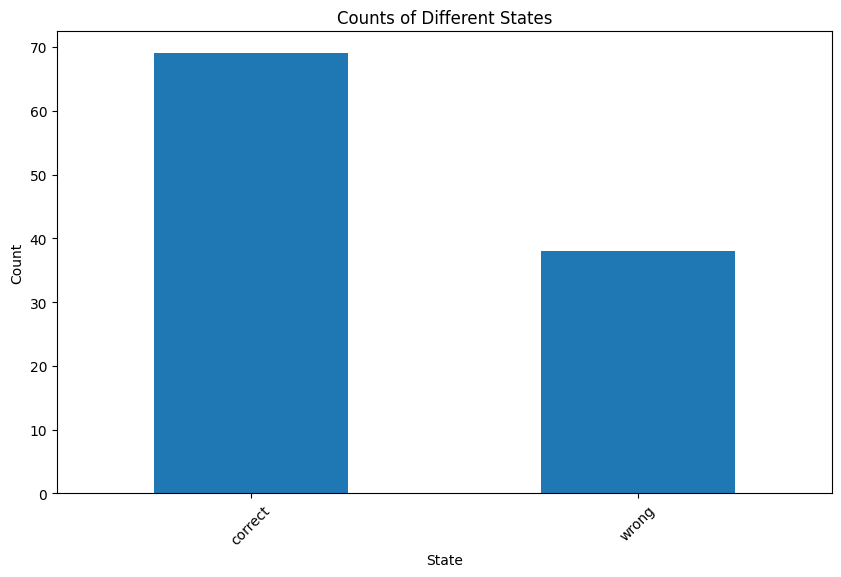

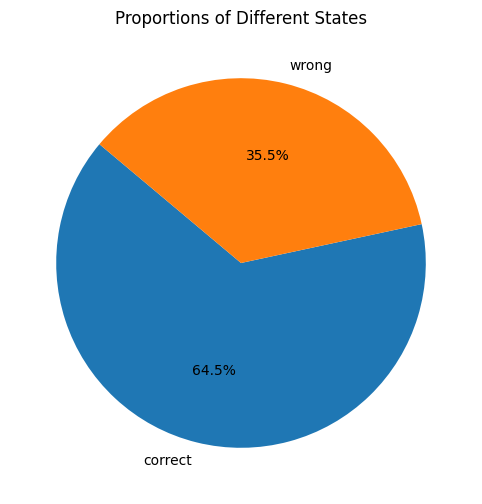

<Figure size 1200x800 with 0 Axes>

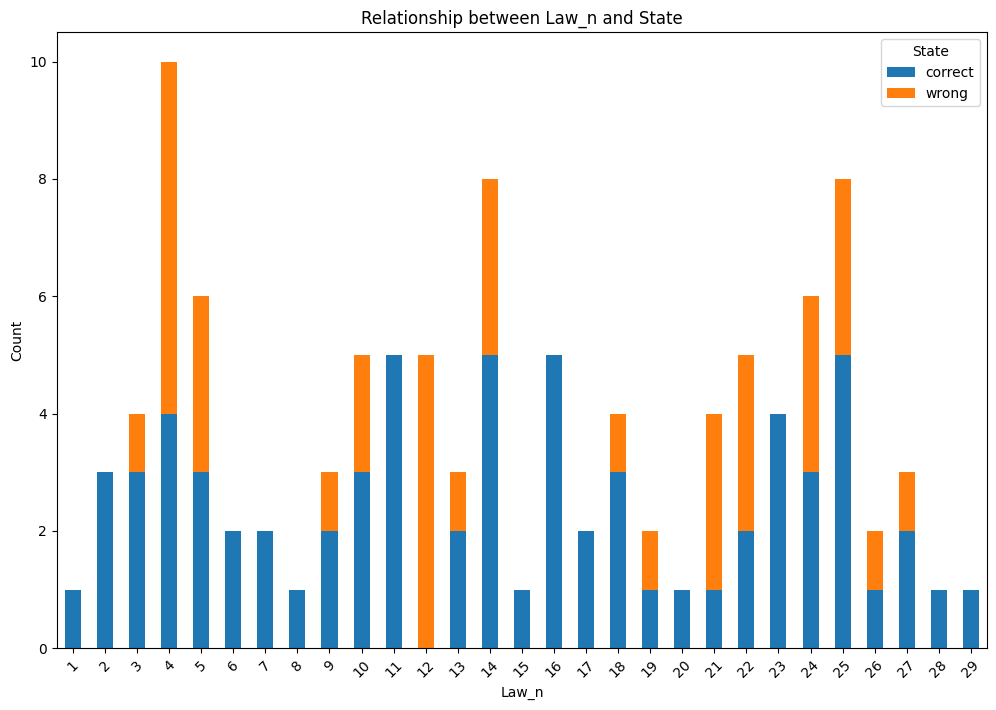

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
file_path = "evaluate_MEU/experiment_1/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.xlsx"
df = pd.read_excel(file_path)

# 统计各种state出现的数量和比例
state_counts = df['state'].value_counts()
state_proportions = df['state'].value_counts(normalize=True)

# 打印统计结果
print("State Counts:")
print(state_counts)
print("\nState Proportions:")
print(state_proportions)

# 绘制各种state出现的数量的柱状图
plt.figure(figsize=(10, 6))
state_counts.plot(kind='bar')
plt.title('Counts of Different States')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 绘制各种state出现的比例的饼图
plt.figure(figsize=(10, 6))
state_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Proportions of Different States')
plt.ylabel('')
plt.show()

# 可视化law_n和state的关系
plt.figure(figsize=(12, 8))
law_n_state_counts = df.groupby(['law_n', 'state']).size().unstack(fill_value=0)
law_n_state_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Relationship between Law_n and State')
plt.xlabel('Law_n')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='State')
plt.show()